# Challenge 
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are ***tasked with predicting their daily sales for up to six weeks in advance***. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

# Predict Store Sales 
***What we learn from this notebook***

1. **Data Collection and Preparation**
   * Gather Data
   * Remove **TOTALLY** unrelated columns from dataset
   * Encode cateorical features
   * Handle too many unique values in categorical features (Cordinality)
   * Missing value handling 
  
  
2. **Exploratory Data Analysis (EDA)**
   * Remove outliers
   * Understand data distribution (mean, median, mode, standard deviation).
   * Check for correlations & covariance between features.
   
   
3. **Feature Selection & Engineering**
   *  Select relevant features based on correlation, mutual information, feature importance, Lasso, RFE, R-squared, p-values, and VIF.
   * Create new features if necessary.
   
   
4. **Check for Assumptions of Linear Regression**
   * **Linearity**: The relationship between predictors and the target should be linear.
   * **Independence**: Observations should be independent of each other,
   * **Homoscedasticity**: Constant variance of the residuals
   * **Normality of Residuals**: Residuals should be normally distributed.
   * **No Multicollinearity**: Predictors should not be highly correlated with each other.
   
   
5. **Model Training**
   * Split data into training and testing sets.
   * Train the multiple linear regression model.
   
   
6. **Model Evaluation**
   * Evaluate the model using metrics like R-squared, adjusted R-squared, Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).
   * Check residual plots to ensure assumptions are met.
   
   
7. **Predict Sales based on new model created**
 

## 1. Data Collection and Preparation

In [378]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)
        print (full_path)
        if "store.csv" in full_path:
            df_store = pd.read_csv(full_path)
        elif "train.csv" in full_path:
            df_train = pd.read_csv(full_path)
        elif "test.csv" in full_path:
            df_test = pd.read_csv(full_path)
                                 
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales-dataset/store.csv
/kaggle/input/rossmann-store-sales-dataset/train.csv


/tmp/ipykernel_33/1702920036.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(full_path)


/kaggle/input/rossmann-store-sales-dataset/test.csv


### Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [379]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [380]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


#### Check the SHAPE of each DataFrame
#### Merge the train and store data based on the store id to have all associated feature of store in single row

In [381]:
dfs =[df_store,df_train]
for df in dfs:
    #print (df)
    print (df.shape)

(1115, 10)
(1017209, 9)


In [382]:
df = df_train.merge (df_store, how="left", on="Store")
print (df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

#### Intuitive Approach In Prediction
##### 1.  How *Promo, stateHoliday, SchoolHoliday, Promo2, Promo2SinceWeek* and *Promo2SinceYear* impacted the sales in a store?
  * Whats impact of question#1 in a year, month and weeks. 
      * 2 What's the impact of season in a year impacted the sales in a store?
      * 1.3 What's the impact of the weekend in a year impacted sales in a store?
      * 1.4 How Open on weekend, weekday StateHoliday, SchooldHliday impacted the sales in Store?
      * 1.5 Was there a impact on sales in stores for a month in a given year?
##### 2.  How much sales impacted in a store becuase of these *CompetitionOpenSinceMonth* and *CompetitionOpenSinceYear*?
##### 3.  How much *PromoInterval* impacted the sales in a store?
##### 4. 

### Fix The Data Types 

In [384]:
df['Date'].isnull().sum()

0

In [385]:
df['Date'] = pd.to_datetime(df['Date'])

In [386]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Missing Values Handling

In [387]:
df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### Handling missing value for the feature CompetitionDistance

In [388]:
df[df['CompetitionDistance'].isnull()].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1405,291,4,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
1736,622,4,2015-07-30,5412,406,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN


#### Checking if there is a relation between other features with the CompetitionDistance

In [389]:
print (df['CompetitionDistance'].isnull().sum() )
print (df['CompetitionOpenSinceMonth'].isnull().sum() )
print (df['CompetitionOpenSinceYear'].isnull().sum() )

2642
323348
323348


#### Looks there is close relation between these features 

In [390]:
df[df['CompetitionDistance'].isna() & df['CompetitionOpenSinceMonth'].isna() & df['CompetitionOpenSinceYear'].isna()].shape

(2642, 18)

#### Lets try to find if there are any Store has its distance already present but only missed at Ramdon 

In [391]:
# Group by 'Store' and check for both NaN and non-NaN values in 'CompetitionDistance'
store_groups = df.groupby('Store')['CompetitionDistance'].agg(
    missing_count = lambda x: x.isna().sum(),
    non_missing_count = lambda x: x.notna().sum()
).reset_index()

# Filter stores that have both missing and non-missing values
stores_with_both = store_groups[(store_groups['missing_count'] > 0) & (store_groups['non_missing_count'] > 0)]

# Display the result
print("Stores with both missing and non-missing CompetitionDistance")
stores_with_both

Stores with both missing and non-missing CompetitionDistance


,Store,missing_count,non_missing_count


No such store where it has value in CompetitionDistance and null at other places CompetitionDistance

#### Lets find the list Stores have the null value in all of these 3 features 

In [392]:
nan_df = df[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]

In [393]:
nan_df.groupby('Store')['CompetitionDistance'].size()

Store
1       942
2       942
3       942
4       942
5       942
       ... 
1111    942
1112    942
1113    942
1114    942
1115    942
Name: CompetitionDistance, Length: 1115, dtype: int64

### From above its clearn that only 3 Stores have missing value in all these 3 features. 
**Row percentage of these 3 stores contributes only 0.25% of total.**

**This is an *MISSING at RANdom (MAR)* patttern for these 3 stores.**

**Based on the StoreType and Assortment of other stores, I assume these 3 stores will also have same distance as compitator** 

In [394]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [395]:
stores_to_exclude = [291, 622, 879]
store_type_291=['d']
assortment_291=['a']
mask_291 = df[(~df['Store'].isin(stores_to_exclude)) & (df['StoreType'].isin(store_type_291)) & (df['Assortment'].isin(assortment_291))]

In [396]:

stores_to_exclude = [622, 879]
store_type_622=['a']
assortment_622=['c']
mask_622 = df[(~df['Store'].isin(stores_to_exclude)) & (df['StoreType'].isin(store_type_622)) & (df['Assortment'].isin(assortment_622))]

In [397]:

stores_to_exclude = [879]
store_type_879=['d']
assortment_879=['a']
mask_879 = df[(~df['Store'].isin(stores_to_exclude)) & (df['StoreType'].isin(store_type_879)) & (df['Assortment'].isin(assortment_879))]

In [398]:
print (mask_879.shape)
print (mask_879.info())
mask_879.head()

(112826, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 112826 entries, 12 to 1017197
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      112826 non-null  int64         
 1   DayOfWeek                  112826 non-null  int64         
 2   Date                       112826 non-null  datetime64[ns]
 3   Sales                      112826 non-null  int64         
 4   Customers                  112826 non-null  int64         
 5   Open                       112826 non-null  int64         
 6   Promo                      112826 non-null  int64         
 7   StateHoliday               112826 non-null  object        
 8   SchoolHoliday              112826 non-null  int64         
 9   StoreType                  112826 non-null  object        
 10  Assortment                 112826 non-null  object        
 11  CompetitionDistance        111884 non-null

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
19,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
22,23,5,2015-07-31,7273,560,1,1,0,1,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN
25,26,5,2015-07-31,7818,611,1,1,0,1,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
37,38,5,2015-07-31,7434,608,1,1,0,1,d,a,1090.0,4.0,2007.0,0,NaN,NaN,NaN


In [399]:
print (mask_622.shape)
print (mask_622.info())
mask_622.head()

(204296, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 204296 entries, 6 to 1017207
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      204296 non-null  int64         
 1   DayOfWeek                  204296 non-null  int64         
 2   Date                       204296 non-null  datetime64[ns]
 3   Sales                      204296 non-null  int64         
 4   Customers                  204296 non-null  int64         
 5   Open                       204296 non-null  int64         
 6   Promo                      204296 non-null  int64         
 7   StateHoliday               204296 non-null  object        
 8   SchoolHoliday              204296 non-null  int64         
 9   StoreType                  204296 non-null  object        
 10  Assortment                 204296 non-null  object        
 11  CompetitionDistance        204296 non-null 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN


In [400]:
print (mask_291.shape)
print (mask_291.info())
mask_291.head()

(111884, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 111884 entries, 12 to 1017197
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      111884 non-null  int64         
 1   DayOfWeek                  111884 non-null  int64         
 2   Date                       111884 non-null  datetime64[ns]
 3   Sales                      111884 non-null  int64         
 4   Customers                  111884 non-null  int64         
 5   Open                       111884 non-null  int64         
 6   Promo                      111884 non-null  int64         
 7   StateHoliday               111884 non-null  object        
 8   SchoolHoliday              111884 non-null  int64         
 9   StoreType                  111884 non-null  object        
 10  Assortment                 111884 non-null  object        
 11  CompetitionDistance        111884 non-null

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
19,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
22,23,5,2015-07-31,7273,560,1,1,0,1,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN
25,26,5,2015-07-31,7818,611,1,1,0,1,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
37,38,5,2015-07-31,7434,608,1,1,0,1,d,a,1090.0,4.0,2007.0,0,NaN,NaN,NaN


In [401]:
# Summary statistics
from scipy.stats import skew, kurtosis
print("Original Data:")
print("Mean:", mask_879['CompetitionDistance'].mean())
print("Median:", mask_879['CompetitionDistance'].median())
print("Skewness:", skew(mask_879['CompetitionDistance']))
print("Kurtosis:", kurtosis(mask_879['CompetitionDistance']))

Original Data:
Mean: 6709.845196810983
Median: 4400.0
Skewness: nan
Kurtosis: nan


In [402]:
# Summary statistics
from scipy.stats import skew, kurtosis
print("Original Data:")
print("Mean:", mask_291['CompetitionDistance'].mean())
print("Median:", mask_291['CompetitionDistance'].median())
print("Skewness:", skew(mask_291['CompetitionDistance']))
print("Kurtosis:", kurtosis(mask_291['CompetitionDistance']))

Original Data:
Mean: 6709.845196810983
Median: 4400.0
Skewness: 2.305205118495136
Kurtosis: 8.81208866389804


In [403]:
# Summary statistics
print("Original Data:")
print("Mean:", mask_622['CompetitionDistance'].mean())
print("Median:", mask_622['CompetitionDistance'].median())
print("Skewness:", skew(mask_622['CompetitionDistance']))
print("Kurtosis:", kurtosis(mask_622['CompetitionDistance']))

Original Data:
Mean: 7022.008752006892
Median: 2330.0
Skewness: 2.806586270422468
Kurtosis: 10.449631701164407


#### Now fill the missing value as CompetitionDistance for the Store 291 

In [404]:
# Fill missing values in 'CompetitionDistance' based on median values as calculated above
df.loc[(df['Store'] == 291) & (df['CompetitionDistance'].isna()), 'CompetitionDistance'] = 4400
df.loc[(df['Store'] == 622) & (df['CompetitionDistance'].isna()), 'CompetitionDistance'] = 2330
df.loc[(df['Store'] == 879) & (df['CompetitionDistance'].isna()), 'CompetitionDistance'] = 4400
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

### Handling missing value for the feature *Promo2SinceWeek*, *Promo2SinceYear* and *PromoInterval*


**Looks like there is a relationship between these columns and lets dig deeper into this**

In [405]:
mask_columns = ['Store','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']
mask = df[mask_columns]
mask.head()

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,0,NaN,NaN,NaN
1,2,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,0,NaN,NaN,NaN
4,5,0,NaN,NaN,NaN


In [406]:
mask[(mask['Promo2SinceWeek'] == 1.0) & (df['Promo2'] == 1 ) & (df['Promo2SinceYear'].notnull()) & (df['PromoInterval'].notnull()) ]

,Store,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
10,11,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
34,35,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
60,61,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
64,65,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
97,98,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...
1017077,983,1,1.0,2014.0,"Jan,Apr,Jul,Oct"
1017078,984,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
1017087,994,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
1017144,1051,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


In [407]:
print (mask['Promo2SinceWeek'].min())
print (mask['Promo2SinceWeek'].max())

1.0
50.0


In [408]:
mask['Promo2SinceWeek'].describe()

count    509178.000000
mean         23.269093
std          14.095973
min           1.000000
25%          13.000000
50%          22.000000
75%          37.000000
max          50.000000
Name: Promo2SinceWeek, dtype: float64

In [409]:
mask['Promo2SinceWeek'].median()

22.0

**We can notice that if *Promo2* value is 0, *Promo2SinceWeek* has missing value.**

**Intuitively, its correct to have null value in those 3 fearures because if *Promo* is not applied, then monthwise, yearwise and internval is expected null value only**

**Let's fill the minimum value in those NULL values because its MAR and there is relation between these columns. Filling minimum will be appropriate**

In [410]:
# Calculate the minimum value of Promo2SinceWeek, ignoring NaNs
min_promo2_since_week = df['Promo2SinceWeek'].min()

# Fill missing values in Promo2SinceWeek with the minimum value where Promo2 is 0
df.loc[(df['Promo2'] == 0) & (df['Promo2SinceWeek'].isna()), 'Promo2SinceWeek'] = min_promo2_since_week

**We can notice that if *Promo2* value is 0, *Promo2SinceYear* has missing value.**

**Intuitively, its correct to have null value in this fearure because if *Promo2* is not applied, then monthwise, yearwise and internval is expected null value only**

**Let's fill the max value of *Promo2SinceYear* in those NULL values because its MAR and there is relation between these columns. Filling maximum will be appropriate**

In [411]:
print (mask['Promo2SinceYear'].min())
print (mask['Promo2SinceYear'].max())

2009.0
2015.0


In [412]:
# Calculate the maximum value of Promo2SinceYear, ignoring NaNs
max_promo2_since_year = df['Promo2SinceYear'].max()

# Fill missing values in Promo2SinceYear with the maximum year where Promo2 is 0 and Promo2SinceWeek was filled with 1
df.loc[(df['Promo2'] == 0) & (df['Promo2SinceYear'].isna()), 'Promo2SinceYear'] = max_promo2_since_year


**We can notice that if *Promo2* value is 0, *Promo2Interval* has missing value.**

**Intuitively, its correct to have null value in this fearure because if *Promo2* is not applied, then monthwise, yearwise and internval is expected null value only**

**Also, we choose *Promo2SinceWeek* and *Promo2SinceYear* as min and max respectively, it happened for me to calculate what was the most used Promo2Interval for Promo2SinceYear when its max value, so that its appropriate to apply this value.**

In [413]:
df['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     293122
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: count, dtype: int64

In [414]:
# Calculate the maximum value of Promo2SinceYear, ignoring NaNs
max_promo2_since_year = df['Promo2SinceYear'].max()

# Filter the DataFrame where Promo2SinceYear is the maximum value
filtered_df = df[df['Promo2SinceYear'] == max_promo2_since_year]

# Get the count of each unique value in 'PromoInterval' column for the filtered DataFrame
promo_interval_counts = filtered_df['PromoInterval'].value_counts()


In [415]:
# Fill missing values in Promo2SinceWeek with the minimum value where Promo2 is 0
df.loc[(df['Promo2'] == 0) & (df['PromoInterval'].isna()), 'PromoInterval'] = "Jan,Apr,Jul,Oct"

### Handling missing value for the features *CompetitionOpenSinceMonth* and *CompetitionOpenSinceYear*


In [416]:
df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
dtype: int64

In [417]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"


In [418]:
mask = df[(df['CompetitionOpenSinceMonth'].isna()) & (df['CompetitionOpenSinceYear'].isna())]

In [419]:
mask.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,5,2015-07-31,8959,962,1,1,0,1,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,5,2015-07-31,10231,979,1,1,0,1,a,c,3270.0,NaN,NaN,0,1.0,2015.0,"Jan,Apr,Jul,Oct"
18,19,5,2015-07-31,8234,718,1,1,0,1,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,5,2015-07-31,6566,633,1,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [420]:
print (mask['Store'].value_counts())

Store
12      942
742     942
734     942
732     942
731     942
       ... 
132     758
243     758
1004    758
851     758
498     758
Name: count, Length: 354, dtype: int64


In [421]:
print (df['CompetitionOpenSinceMonth'].min() )
print (df['CompetitionOpenSinceMonth'].max() )

print (df['CompetitionOpenSinceYear'].min())
print (df['CompetitionOpenSinceYear'].max())

1.0
12.0
1900.0
2015.0


In [422]:
# Group by 'Store' and check for both NaN and non-NaN values in 'CompetitionDistance'
store_groups = df.groupby('Store')['Promo2'].agg(
    missing_count = lambda x: x.isna().sum(),
    non_missing_count = lambda x: x.notna().sum()
).reset_index()

# Filter stores that have both missing and non-missing values
stores_with_both = store_groups[(store_groups['missing_count'] > 0) & (store_groups['non_missing_count'] > 0)]

# Display the result
print("Stores with both missing and non-missing CompetitionDistance")
stores_with_both

Stores with both missing and non-missing CompetitionDistance


,Store,missing_count,non_missing_count


In [423]:
mask['Store'].nunique()

354

### Around 30% of stores having null value in *CompetitionOpenSinceMonth* and *CompetitionOpenSinceYear*
**These variables are about factual data. Filling data based on any method may misslead the model. So, lets see the feature importance in latest section and if needed, we shall allow train method to handle the missling value take a decision whether these features really needed or not**

## Encoding The Features

In [424]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,1.0,2015.0,"Jan,Apr,Jul,Oct"


**Check if the *StoreType* and *Assortment* features needed Encoding**

In [425]:
for store_range in range(1,1154):
    mask = df[df['Store'] == store_range]
    asserts = mask['Assortment'].value_counts().count()
    store_type = mask['StoreType'].value_counts().count()
    if  asserts > 1 or store_type > 1:
        print ("Store number : ", asserts)
        print ("Store number : ", store_type)
    #mask.head()

**From the above cell, its clear that each Store sells same type and hence each store has same *StoreType* and *Assortment***

**Lets keep these features and see how it behaves in the Feature Engineering**

**Since its NOMINAL values, lets go with One-Hot Encoding method**

In [426]:
df = pd.get_dummies(df,columns=['StoreType','Assortment'])

In [427]:
#get_dummies results in true and false and we change the data type of get_dummies
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)
    
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,0,1,1270.0,...,1.0,2015.0,"Jan,Apr,Jul,Oct",0,0,1,0,1,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,570.0,...,13.0,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,14130.0,...,14.0,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,620.0,...,1.0,2015.0,"Jan,Apr,Jul,Oct",0,0,1,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1,29910.0,...,1.0,2015.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0


In [428]:
df['PromoInterval'].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     801153
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: count, dtype: int64

### We could see in the above cell that there is a frequency for this feature. Most of the stores choose a type of promointerval, So lets apply Frequency Encoding Method 

In [429]:
# Calculate the frequency of each category
freq_encoding = df['PromoInterval'].value_counts() / len(df)
# Map the frequencies to the original data
df['PromoInterval_freq'] = df['PromoInterval'].map(freq_encoding)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,...,Promo2SinceYear,PromoInterval,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,PromoInterval_freq
0,1,5,2015-07-31,5263,555,1,1,0,1,1270.0,...,2015.0,"Jan,Apr,Jul,Oct",0,0,1,0,1,0,0,0.787599
1,2,5,2015-07-31,6064,625,1,1,0,1,570.0,...,2010.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,0.787599
2,3,5,2015-07-31,8314,821,1,1,0,1,14130.0,...,2011.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,0.787599
3,4,5,2015-07-31,13995,1498,1,1,0,1,620.0,...,2015.0,"Jan,Apr,Jul,Oct",0,0,1,0,0,0,1,0.787599
4,5,5,2015-07-31,4822,559,1,1,0,1,29910.0,...,2015.0,"Jan,Apr,Jul,Oct",1,0,0,0,1,0,0,0.787599


# Exploratory Data Analysis (EDA)

## EDA for Continuous Feature

Sales  Mean:  5773.818972305593
Sales  Median:  5744.0
Sales  Std. Div:  3849.92617523476
Sales  Skewness:  0.641458669898754
Sales  Kurtosis:  1.7783601073200126
Sales : Highly skewed data: Apply square root transformation


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


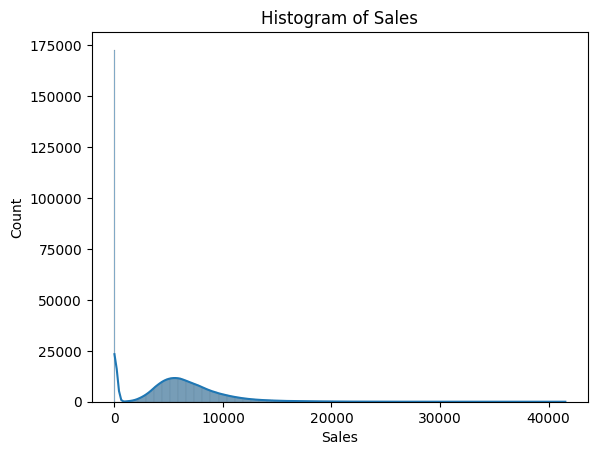

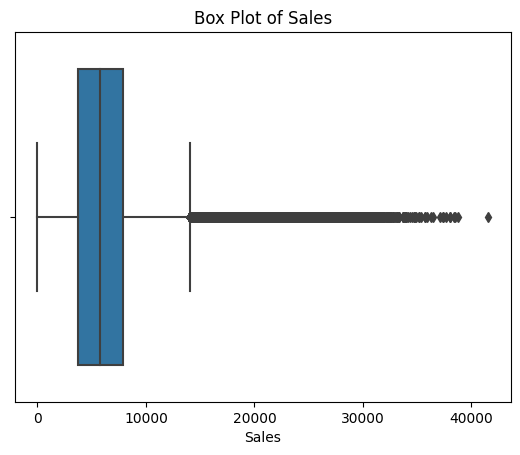

Customers  Mean:  633.1459464082602
Customers  Median:  609.0
Customers  Std. Div:  464.4117338866325
Customers  Skewness:  1.5986479325431053
Customers  Kurtosis:  7.0917319603414075
Customers : Highly skewed data: apply log transformation


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


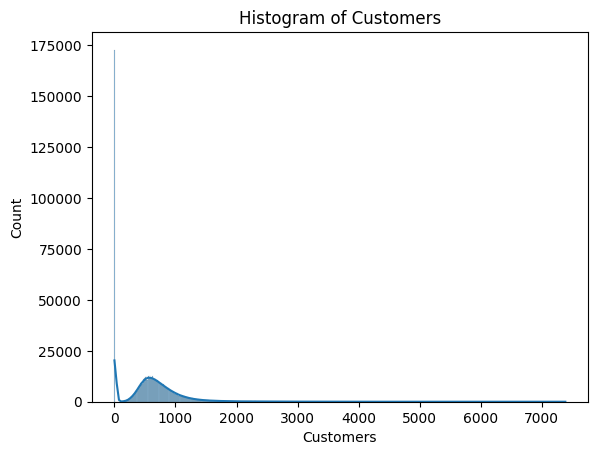

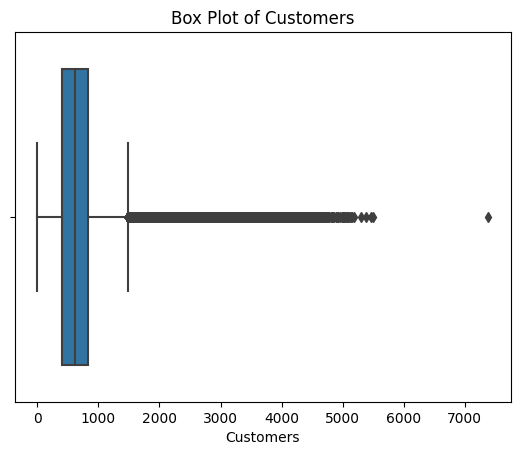

CompetitionDistance  Mean:  5425.493256548064
CompetitionDistance  Median:  2330.0
CompetitionDistance  Std. Div:  7705.988853623713
CompetitionDistance  Skewness:  2.933274836594938
CompetitionDistance  Kurtosis:  13.042877654718051
CompetitionDistance : Highly skewed data: apply log transformation


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


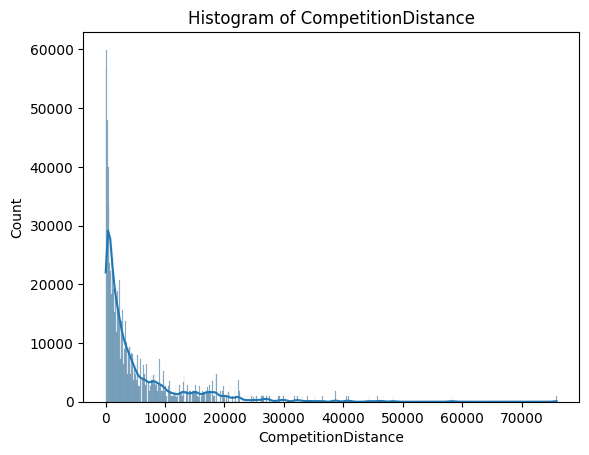

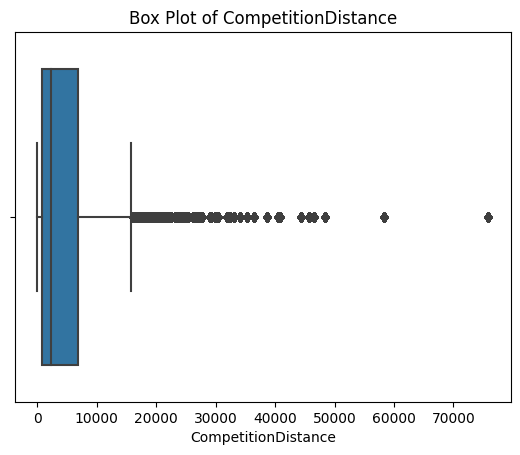

In [430]:
import matplotlib.pyplot as plt
import seaborn as sns
num_columns = ['Sales','Customers','CompetitionDistance']
for col in num_columns:
    print (col," Mean: ", df[col].mean())
    print (col," Median: ", df[col].median())
    print (col, " Std. Div: ", df[col].std())
    print (col," Skewness: ", skew(df[col]))
    
    skewness = skew(df[col])
    print (col," Kurtosis: ", kurtosis(df[col]))
    
    #Calculate the Skewness and its interference 
    if skewness > 1 or skewness < -1:
        print (col,": Highly skewed data: apply log transformation")
    elif 0.5 < skewness <= 1 or -1 <= skewness < -0.5:
        print (col,": Highly skewed data: Apply square root transformation")
    else:
        print (col,": Looks, its symmetric data")
        
    
    # Histogram
    sns.histplot(df[col], kde=True)
    hist_title = 'Histogram of '+col
    plt.title(hist_title)
    plt.show()
    # Box plot
    box_title = 'Box Plot of '+col
    sns.boxplot(x=df[col])
    plt.title(box_title)
    plt.show()


#### We could see there is highly Skewed data and Kurtosis. Let's get the ourlier info


In [431]:
columns_interested = ['Sales','Customers','CompetitionDistance']
num_columns = ['Sales','Customers','CompetitionDistance']
for col in columns_interested:
    print ("IQR for the Column: ", col)
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.20)
    Q3 = df[col].quantile(0.80)
    IQR = Q3 - Q1

    print(f"First Quartile (Q1): {Q1}")
    print(f"Third Quartile (Q3): {Q3}")
    print(f"Interquartile Range (IQR): {IQR}")

    #Identify Outliers
    # Calculate bounds for outliers
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    print ("lower_bound: ",lower_bound)
    print ("upper_bound: ",upper_bound)
    print ("IQR: ",IQR)

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    #print ("outliers: ", outliers)

    print("Outliers identified by IQR method:")
    print(outliers[col].value_counts())
    # Remove outliers
    
    #df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    #df[col].value_counts().sum()
    
    print (" ")


IQR for the Column:  Sales
First Quartile (Q1): 2937.0
Third Quartile (Q3): 8461.0
Interquartile Range (IQR): 5524.0
lower_bound:  -5349.0
upper_bound:  16747.0
IQR:  5524.0
Outliers identified by IQR method:
Sales
16903    10
16837    10
16967     9
17596     9
20710     9
         ..
20522     1
17322     1
18852     1
20706     1
23303     1
Name: count, Length: 5863, dtype: int64
 
IQR for the Column:  Customers
First Quartile (Q1): 325.0
Third Quartile (Q3): 903.0
Interquartile Range (IQR): 578.0
lower_bound:  -542.0
upper_bound:  1770.0
IQR:  578.0
Outliers identified by IQR method:
Customers
1772    81
1783    72
1815    68
1799    64
1788    63
        ..
4119     1
4009     1
5034     1
4000     1
4065     1
Name: count, Length: 2377, dtype: int64
 
IQR for the Column:  CompetitionDistance
First Quartile (Q1): 510.0
Third Quartile (Q3): 8670.0
Interquartile Range (IQR): 8160.0
lower_bound:  -11730.0
upper_bound:  20910.0
IQR:  8160.0
Outliers identified by IQR method:
Competit

### From the Outliers, its evident that having Sales and Customer value <= 0 considers it as outlier.. 

Significant Events: High sales might be due to significant events like promotions, holidays, or new product launches. If these events are relevant to your analysis, you should retain the outliers.

I dont think, these are outliers due to error. So, retaining Sales and Customers feature with outliers will help us for better prediction 

Simillarly, the Competitor distance also it considers and it has relation with Store location and hence we should not be consider it as outlier

## Lets see how transformation helps us in brining non-skewed and non-kurtosis features

Skewness: 0.64


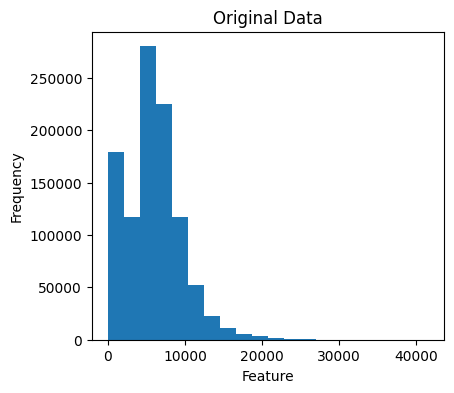

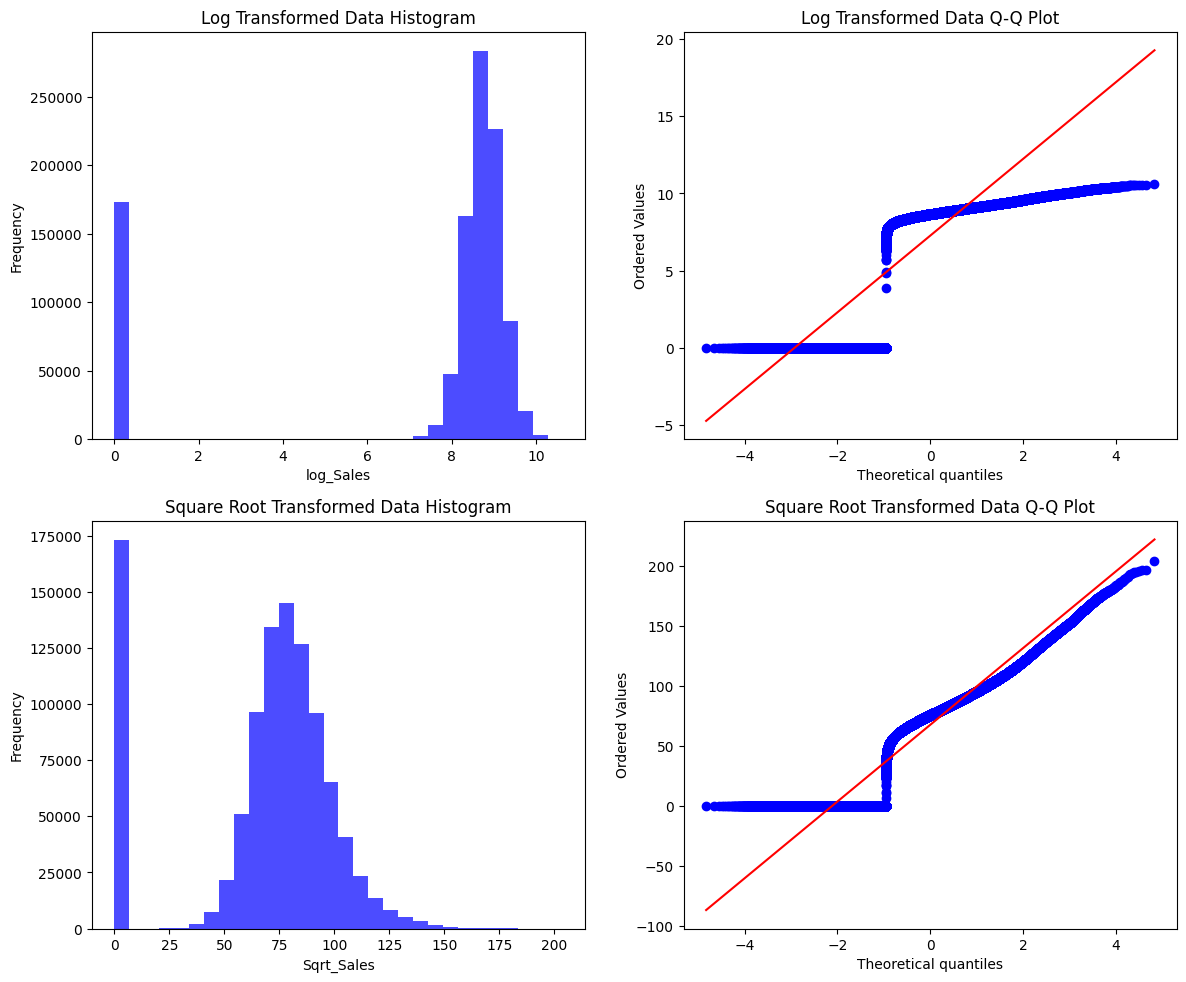

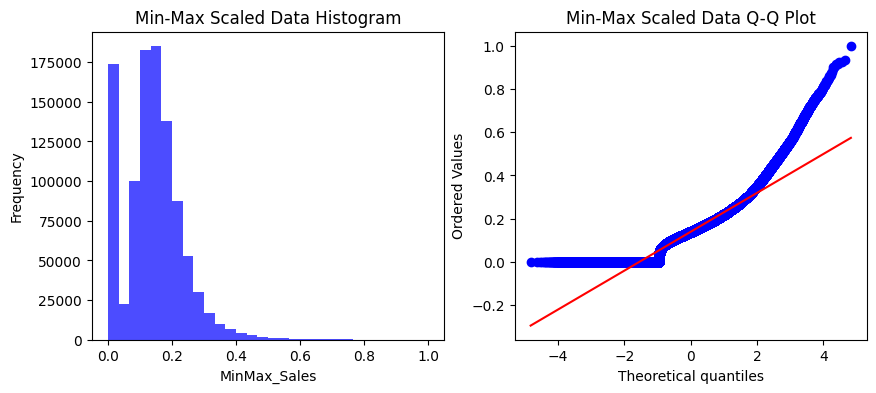

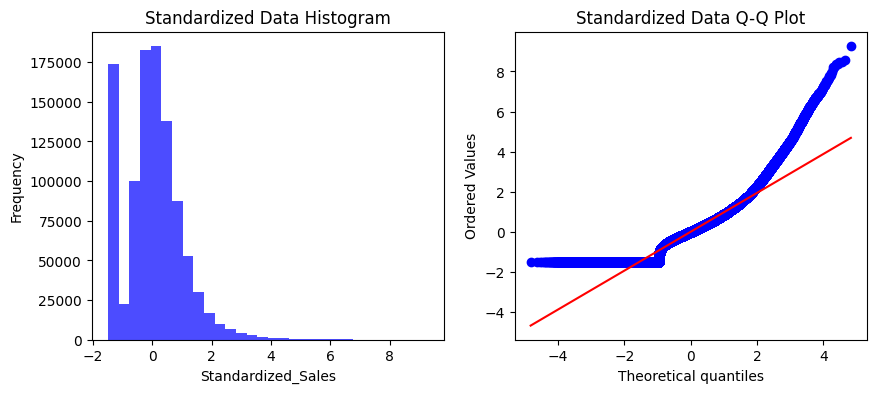

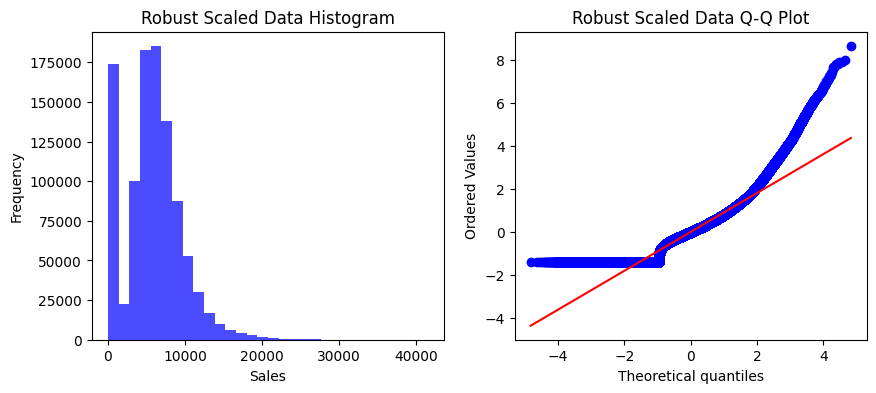

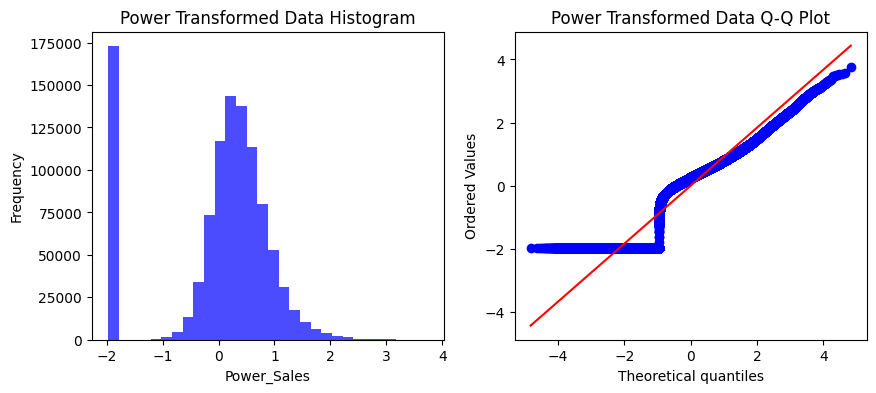

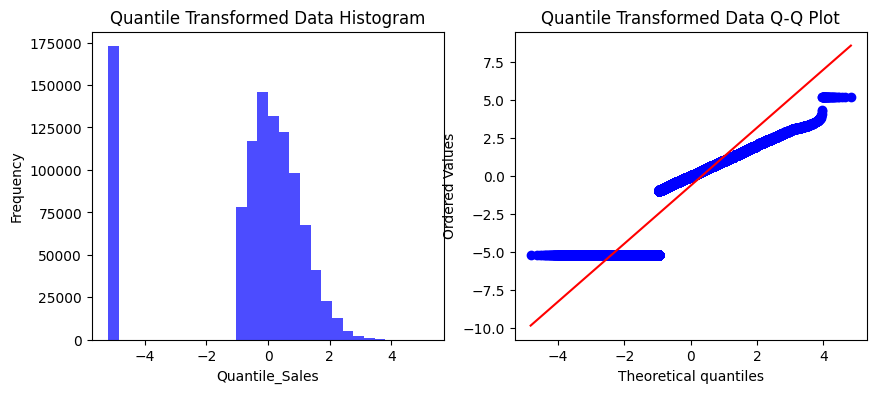

Skewness: 1.60


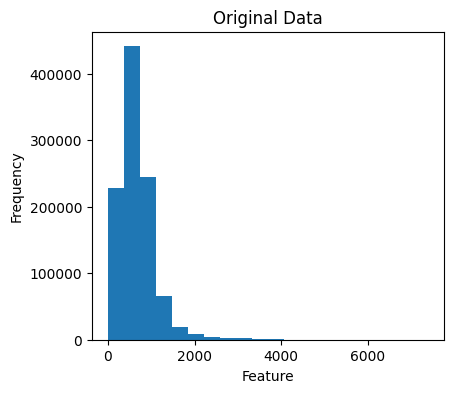

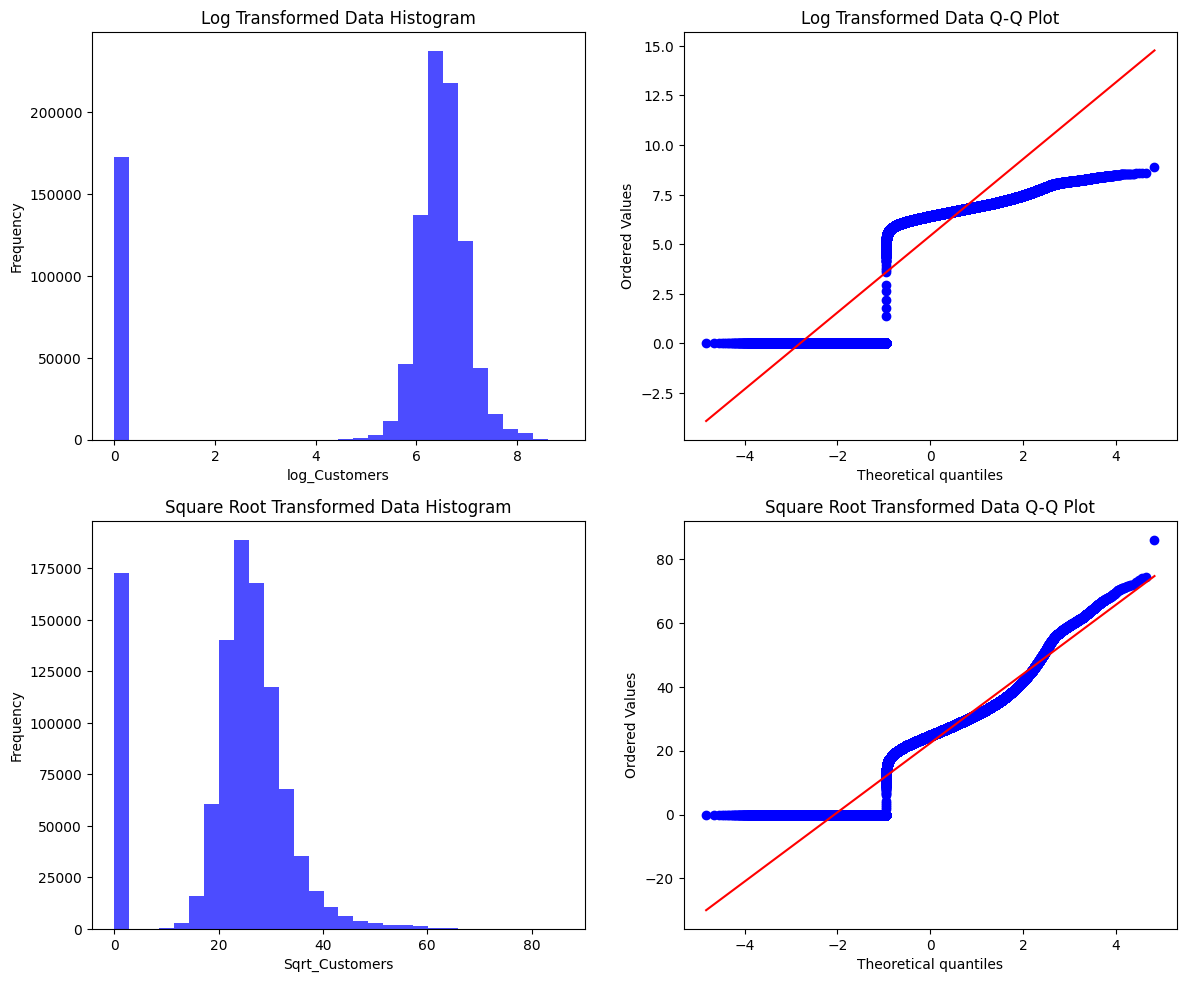

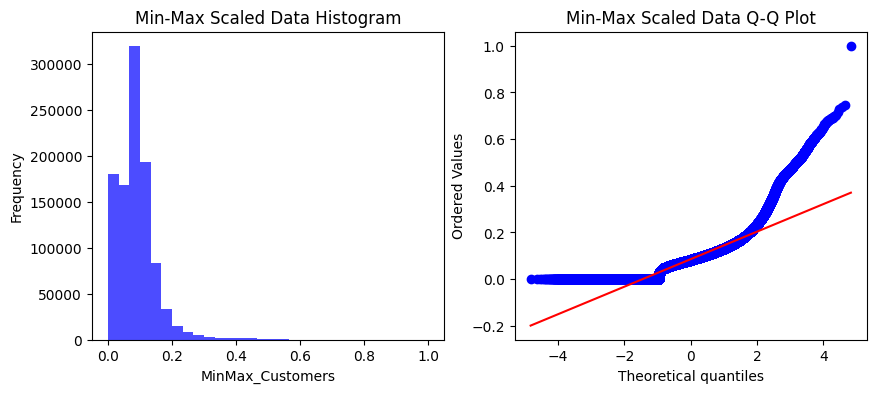

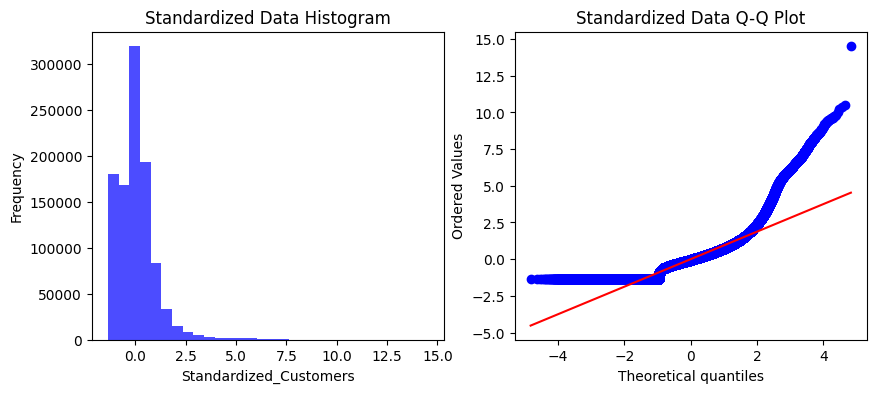

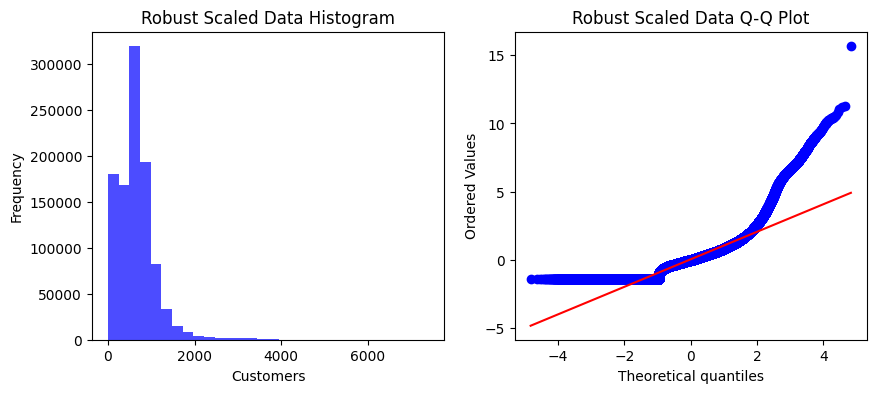

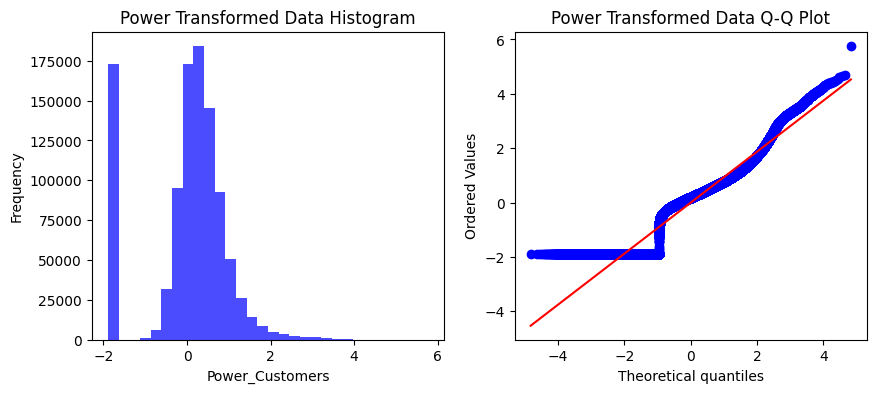

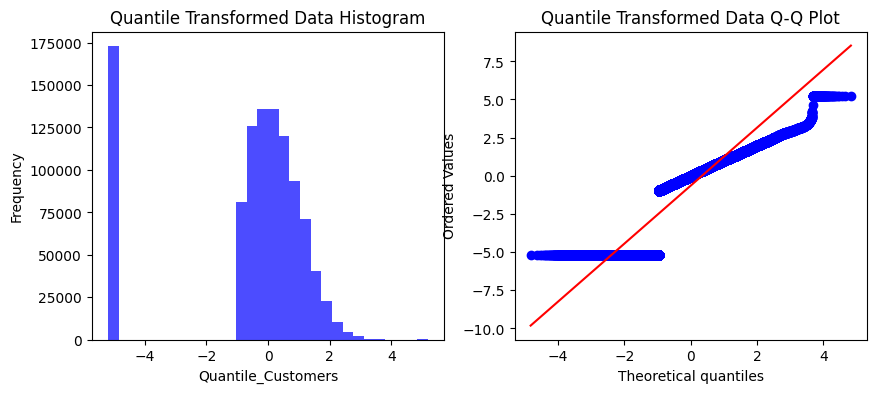

Skewness: 2.93


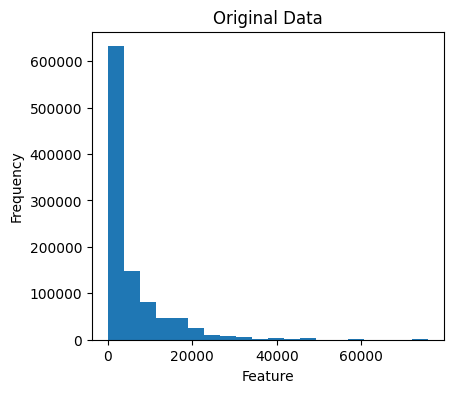

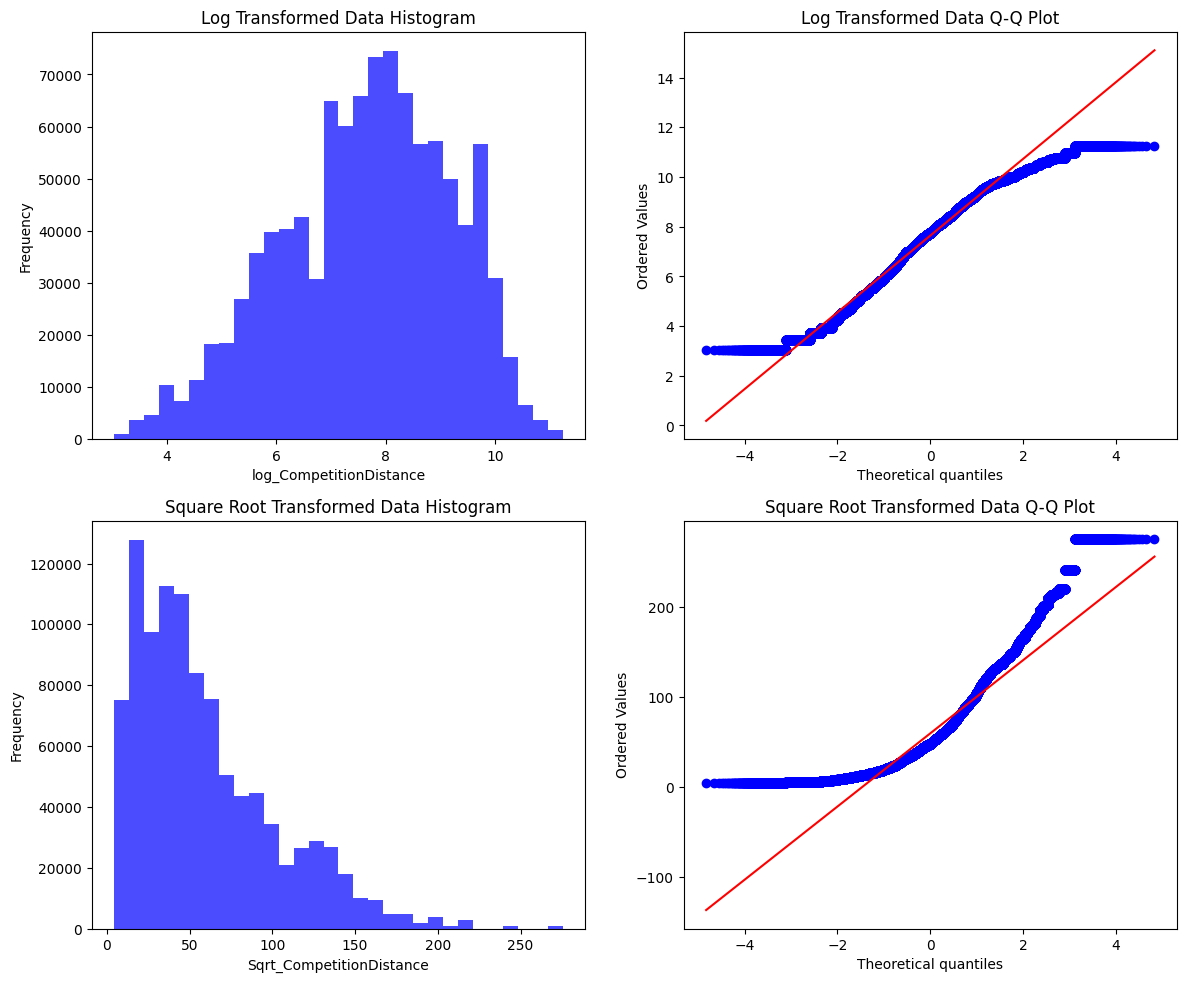

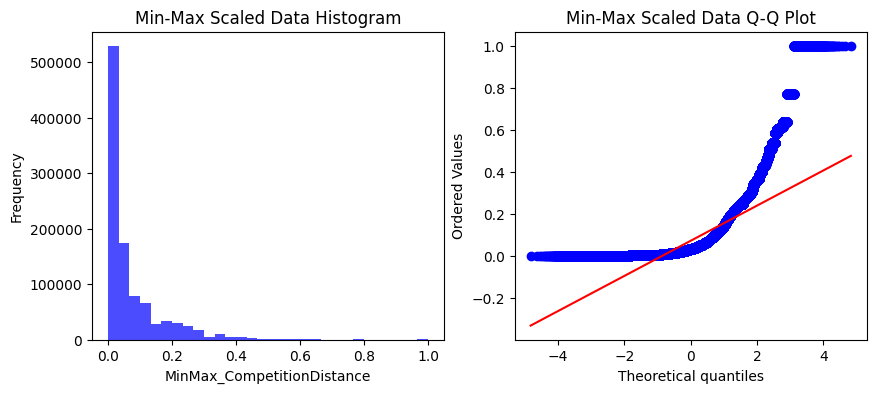

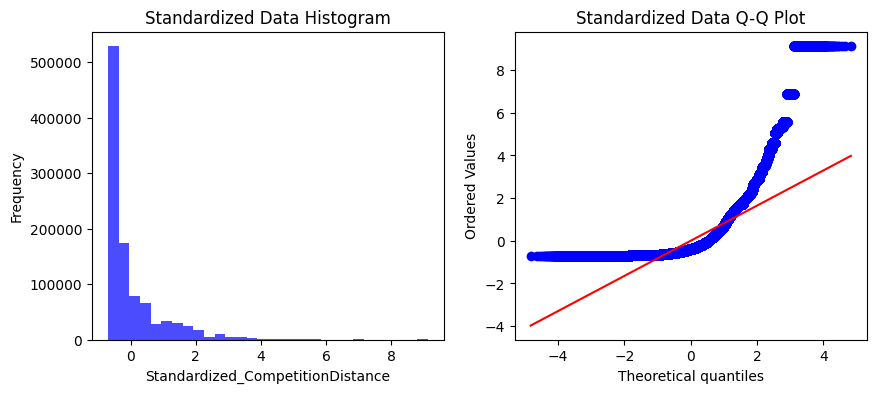

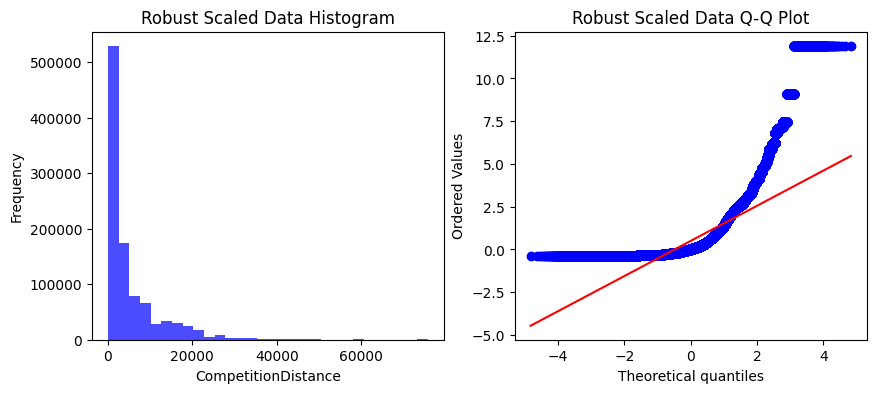

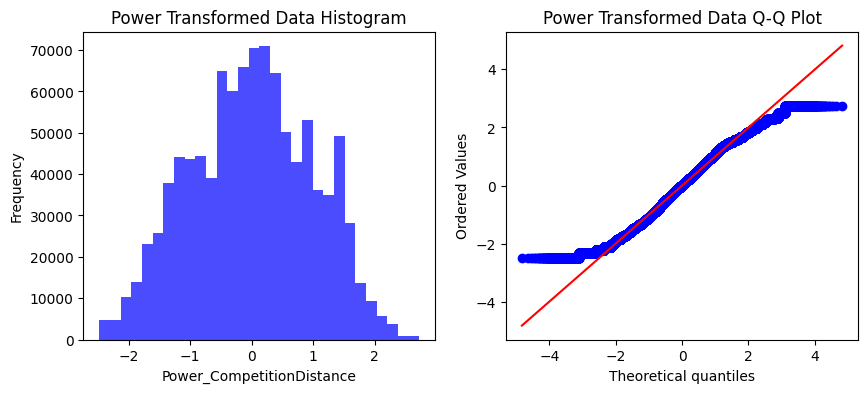

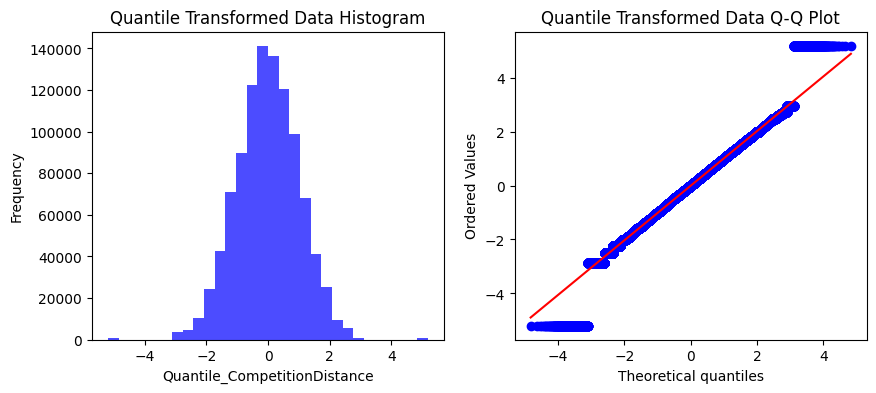

In [432]:
#Example - Log Transformation
#Calculate Skewness:
#Apply Log Transformation Based on Threshold:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, boxcox, probplot

num_columns = ['Sales','Customers','CompetitionDistance']
for col in num_columns:
    
    # Calculate skewness
    skewness = df[col].skew()
    print(f"Skewness: {skewness:.2f}")

    # Plot original data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=20)
    plt.title('Original Data')
    plt.xlabel('Feature')
    plt.ylabel('Frequency')

    '''
    # Apply log transformation if skewness > 1
    if skewness > 1:
        df['Log_Feature'] = np.log1p(df[col])
        transformed = True
    else:
        df['Log_Feature'] = df[col]
        transformed = False

    # Plot transformed data
    plt.subplot(1, 2, 2)
    plt.hist(df['Log_Feature'], bins=30)
    plt.title('Log Transformed Data' if transformed else 'Data without Transformation')
    plt.xlabel('Log_Feature' if transformed else 'Feature')
    plt.ylabel('Frequency')

    plt.show()
    '''
    # Apply log transformation
    log_feature = "log_"+col
    df[log_feature] = np.log1p(df[col])

    # Apply square root transformation
    sqrt_feature = "Sqrt_"+col
    df[sqrt_feature] = np.sqrt(df[col])

    # Plot transformed data for comparison
    plt.figure(figsize=(14, 18))

    plt.subplot(3, 2, 1)
    plt.hist(df[log_feature], bins=30, color='blue', alpha=0.7)
    plt.title('Log Transformed Data Histogram')
    plt.xlabel(log_feature)
    plt.ylabel('Frequency')

    plt.subplot(3, 2, 2)
    probplot(df[log_feature], dist="norm", plot=plt)
    plt.title('Log Transformed Data Q-Q Plot')

    plt.subplot(3, 2, 3)
    plt.hist(df[sqrt_feature], bins=30, color='blue', alpha=0.7)
    plt.title('Square Root Transformed Data Histogram')
    plt.xlabel(sqrt_feature)
    plt.ylabel('Frequency')

    plt.subplot(3, 2, 4)
    probplot(df[sqrt_feature], dist="norm", plot=plt)
    plt.title('Square Root Transformed Data Q-Q Plot')

    plt.show()

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    col_name="MinMax_"+col
    df[col_name] = scaler.fit_transform(df[[col]])

    # Plot Min-Max scaled data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col_name], bins=30, color='blue', alpha=0.7)
    plt.title('Min-Max Scaled Data Histogram')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    probplot(df[col_name], dist="norm", plot=plt)
    plt.title('Min-Max Scaled Data Q-Q Plot')

    plt.show()

    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    std_feature = "Standardized_"+col
    df[std_feature] = scaler.fit_transform(df[[col]])

    # Plot standardized data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[std_feature], bins=30, color='blue', alpha=0.7)
    plt.title('Standardized Data Histogram')
    plt.xlabel(std_feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    probplot(df[std_feature], dist="norm", plot=plt)
    plt.title('Standardized Data Q-Q Plot')

    plt.show()

    from sklearn.preprocessing import RobustScaler

    scaler = RobustScaler()
    col_name="Robust_"+col
    df[col_name] = scaler.fit_transform(df[[col]])

    # Plot robust scaled data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=30, color='blue', alpha=0.7)
    plt.title('Robust Scaled Data Histogram')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    probplot(df[col_name], dist="norm", plot=plt)
    plt.title('Robust Scaled Data Q-Q Plot')

    plt.show()

    from sklearn.preprocessing import PowerTransformer

    # Apply Yeo-Johnson transformation (handles zero and negative values)
    power_transformer = PowerTransformer(method='yeo-johnson')
    col_name="Power_"+col
    df[col_name] = power_transformer.fit_transform(df[[col]])

    # Plot power transformed data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col_name], bins=30, color='blue', alpha=0.7)
    plt.title('Power Transformed Data Histogram')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    probplot(df[col_name], dist="norm", plot=plt)
    plt.title('Power Transformed Data Q-Q Plot')

    plt.show()

    from sklearn.preprocessing import QuantileTransformer

    # Apply quantile transformation with normal output distribution
    quantile_transformer = QuantileTransformer(output_distribution='normal')
    col_name="Quantile_"+col
    df[col_name] = quantile_transformer.fit_transform(df[[col]])

    # Plot quantile transformed data
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df[col_name], bins=30, color='blue', alpha=0.7)
    plt.title('Quantile Transformed Data Histogram')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    probplot(df[col_name], dist="norm", plot=plt)
    plt.title('Quantile Transformed Data Q-Q Plot')

    plt.show()

### From the above, having Power Transformation for Sales and Customer features is more realistic

In [433]:
drop_columns = ['log_Sales','Sqrt_Sales','MinMax_Sales','Standardized_Sales','Robust_Sales','Quantile_Sales','log_Customers','Sqrt_Customers','MinMax_Customers','Standardized_Customers','Robust_Customers','Quantile_Customers']

df = df.drop(columns=drop_columns)

Initial Skewness: 2.93
Initial Kurtosis: 13.04


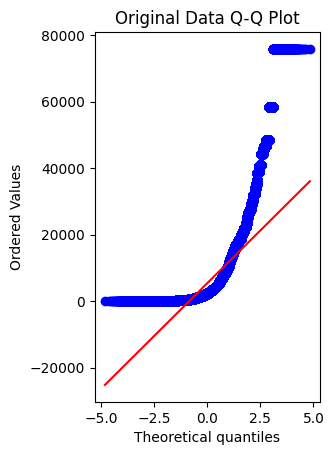

Optimal Lambda: 0.10
Transformed Skewness: -0.03
Transformed Kurtosis: -0.63


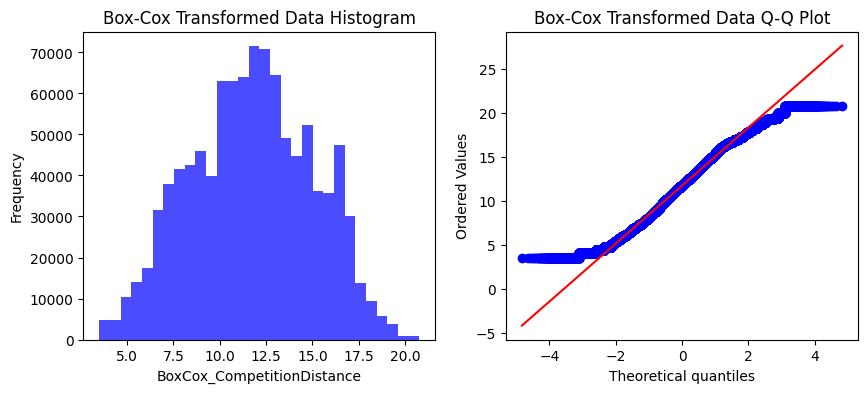

In [435]:
# Check for positive data
if (df['CompetitionDistance'] <= 0).any():
    raise ValueError("Box-Cox transformation requires strictly positive values.")

# Calculate skewness and kurtosis
initial_skewness = skew(df['CompetitionDistance'])
initial_kurtosis = kurtosis(df['CompetitionDistance'])
print(f"Initial Skewness: {initial_skewness:.2f}")
print(f"Initial Kurtosis: {initial_kurtosis:.2f}")


plt.subplot(1, 2, 2)
probplot(df[col], dist="norm", plot=plt)
plt.title('Original Data Q-Q Plot')

plt.show()

# Apply Box-Cox transformation
BoxCox_Feature = "BoxCox_"+"CompetitionDistance"
df[BoxCox_Feature], fitted_lambda = boxcox(df['CompetitionDistance'])
print(f"Optimal Lambda: {fitted_lambda:.2f}")

# Recalculate skewness and kurtosis for transformed data
transformed_skewness = skew(df[BoxCox_Feature])
transformed_kurtosis = kurtosis(df[BoxCox_Feature])
print(f"Transformed Skewness: {transformed_skewness:.2f}")
print(f"Transformed Kurtosis: {transformed_kurtosis:.2f}")

# Plot transformed data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df[BoxCox_Feature], bins=30, color='blue', alpha=0.7)
plt.title('Box-Cox Transformed Data Histogram')
plt.xlabel(BoxCox_Feature)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
probplot(df[BoxCox_Feature], dist="norm", plot=plt)
plt.title('Box-Cox Transformed Data Q-Q Plot')

plt.show()


### Looks BoxCox is suitable for CompetitionDistance

In [436]:
drop_columns = ['Quantile_CompetitionDistance','Power_CompetitionDistance','log_CompetitionDistance','Sqrt_CompetitionDistance','MinMax_CompetitionDistance','Standardized_CompetitionDistance','Robust_CompetitionDistance',]

df = df.drop(columns=drop_columns)

Power_Sales  Mean:  -5.279707723751108e-16
Power_Sales  Median:  0.24549120338601388
Power_Sales  Std. Div:  1.0000004915414322
Power_Sales  Skewness:  -0.9548087590917144
Power_Sales  Kurtosis:  0.12240760571889187
Power_Sales : Highly skewed data: Apply square root transformation


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


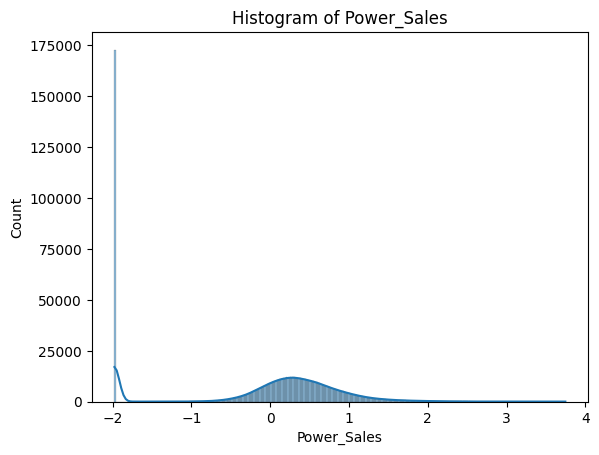

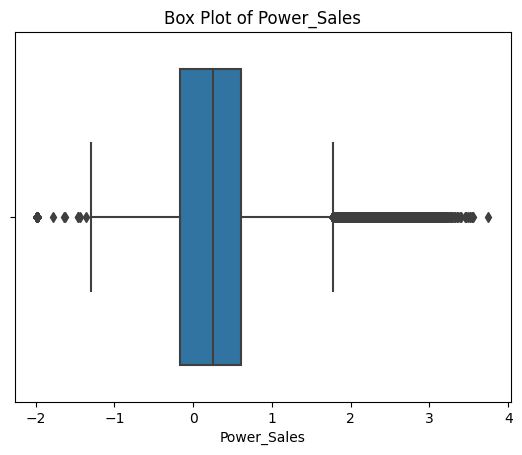

Power_Customers  Mean:  7.398743677229538e-16
Power_Customers  Median:  0.18781645272596534
Power_Customers  Std. Div:  1.0000004915414316
Power_Customers  Skewness:  -0.5846670842955001
Power_Customers  Kurtosis:  0.38295390225909154
Power_Customers : Highly skewed data: Apply square root transformation


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


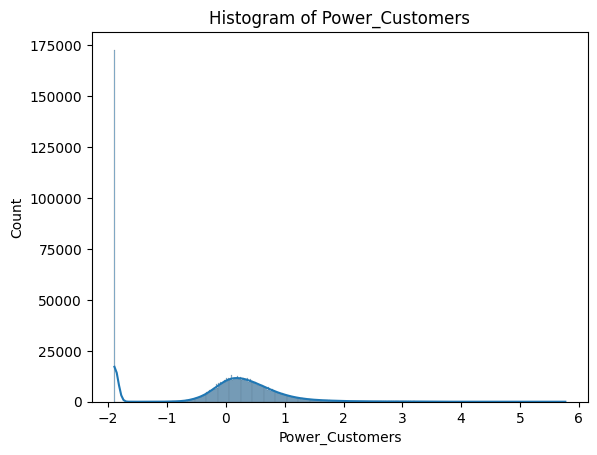

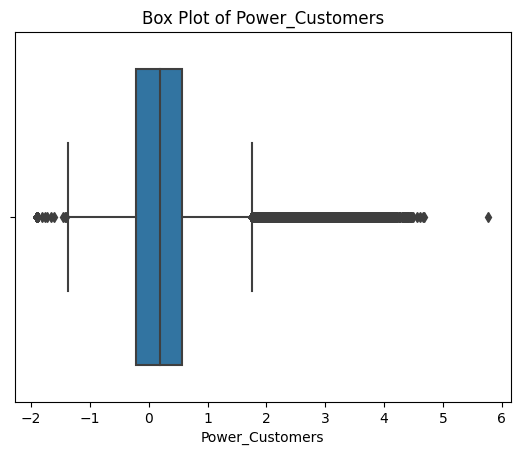

BoxCox_CompetitionDistance  Mean:  11.738963816473527
BoxCox_CompetitionDistance  Median:  11.718920992728487
BoxCox_CompetitionDistance  Std. Div:  3.305254245174194
BoxCox_CompetitionDistance  Skewness:  -0.03322053692575881
BoxCox_CompetitionDistance  Kurtosis:  -0.6277265018421634
BoxCox_CompetitionDistance : Looks, its symmetric data


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


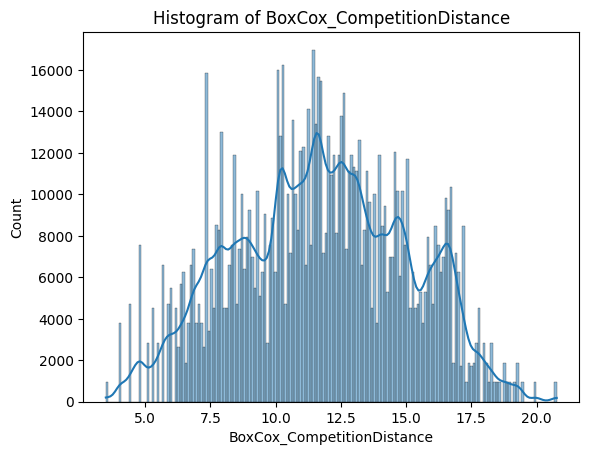

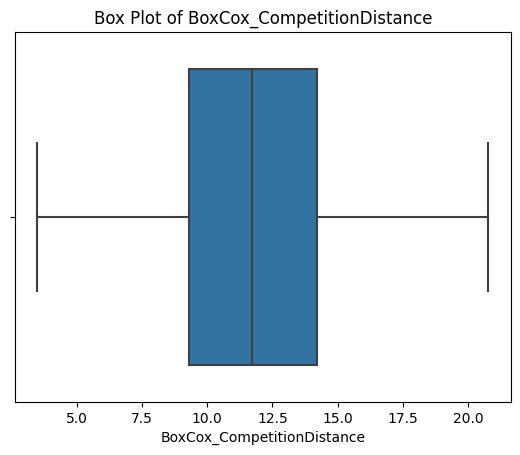

In [439]:
import matplotlib.pyplot as plt
import seaborn as sns
num_columns = ['Power_Sales','Power_Customers','BoxCox_CompetitionDistance']
for col in num_columns:
    print (col," Mean: ", df[col].mean())
    print (col," Median: ", df[col].median())
    print (col, " Std. Div: ", df[col].std())
    print (col," Skewness: ", skew(df[col]))
    
    skewness = skew(df[col])
    print (col," Kurtosis: ", kurtosis(df[col]))
    
    #Calculate the Skewness and its interference 
    if skewness > 1 or skewness < -1:
        print (col,": Highly skewed data: apply log transformation")
    elif 0.5 < skewness <= 1 or -1 <= skewness < -0.5:
        print (col,": Highly skewed data: Apply square root transformation")
    else:
        print (col,": Looks, its symmetric data")
        
    
    # Histogram
    sns.histplot(df[col], kde=True)
    hist_title = 'Histogram of '+col
    plt.title(hist_title)
    plt.show()
    # Box plot
    box_title = 'Box Plot of '+col
    sns.boxplot(x=df[col])
    plt.title(box_title)
    plt.show()
